In [1]:
from tracr.rasp import rasp
from tracr.compiler import compiling
from tracr.compiler import lib

import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\src")

from Model import Model
from functions import *

%load_ext autoreload
%autoreload 2

In [3]:
def saveArray(array, fileName="temp"):
    file = open(fileName, "wb")
    np.save(file, array)
    file.close()

def loadArray(fileNames="temp"):
    if type(fileNames) is list:
        file = open(fileNames[0], "rb")
        array = np.load(file)
        file.close()
        for fn in fileNames[1:]:
            file = open(fn, "rb")
            conAcc = np.load(file)
            array = np.concatenate((array, conAcc), axis=1)
            file.close()
        
    else:
        file = open(fileNames, "rb")
        array = np.load(file)
        file.close()

    return array

### Generate Training Data and Model

In [6]:
maxLength = 5
name = "sort"
N = 5000

model = generateModel(name, maxLength)

np.random.seed(666)
data = generateData(name, maxLength, N)
split = int(len(data) * 0.90)
data_train, data_test = data[:split], data[split:]
split = int(len(data_train) * 0.85)
data_train, data_val = data_train[:split], data_train[split:]
X, Y = encodeAndPadData(data, model.raspFunction, model.inputs, maxLength)

#Split data
split = int(X.shape[0] * 0.90)
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]

split = int(X_train.shape[0] * 0.85)
X_train, X_val = X_train[:split], X_train[split:]
Y_train, Y_val = Y_train[:split], Y_train[split:]

print(X_train[:5])
print(Y_train[:5])

print(X_train.shape, X_val.shape, X_test.shape)
print(Y_train.shape, Y_val.shape, Y_test.shape)
print(len(data_train), len(data_val), len(data_test))

[[6 2 5 7 7 7]
 [6 1 4 5 3 7]
 [6 3 4 4 1 7]
 [6 0 0 5 2 4]
 [6 5 5 5 4 3]]
[[0 2 5 0 0 0]
 [0 1 3 4 5 0]
 [0 1 3 4 4 0]
 [0 0 0 2 4 5]
 [0 3 4 5 5 5]]
(3825, 6) (675, 6) (500, 6)
(3825, 6) (675, 6) (500, 6)
3825 675 500


### Train for a Large Number of Epochs

100%|██████████| 500/500 [03:54<00:00,  2.13it/s]


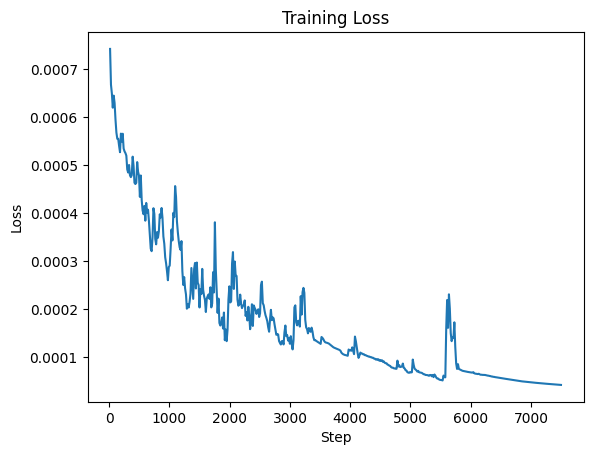

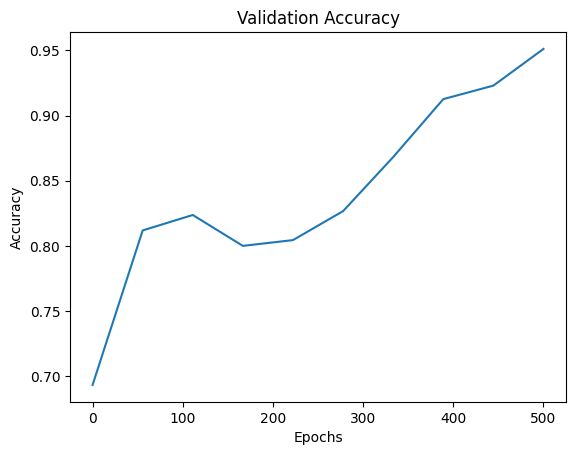

In [7]:
model.resetWeights()

metrics, validations = model.train(X_train, Y_train, n_epochs=500, batch_size=256, lr=1e-4, plot=True, X_val=X_val, Y_val=Y_val, valStep=50)

### Save Resutls

500 [0.00074283 0.00066816 0.00064987 0.00062045 0.00064551] 0.00017334925796562515
10 [0.69333333 0.81185185 0.8237037  0.8        0.80444444] 0.8414814814814815


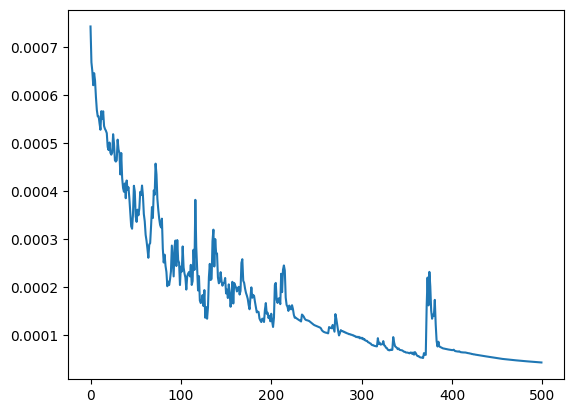

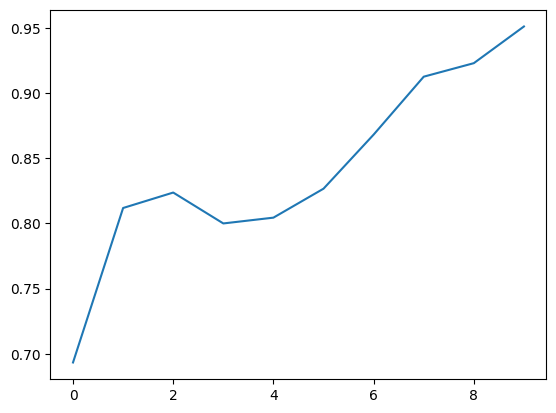

In [8]:
saveDirectory = "savedData/overTraining/"

#Save loss and validation accuracy
saveArray([m["loss"] for m in metrics], saveDirectory + "temp_loss")
saveArray(validations, saveDirectory + "temp_val")

#Load the saved array from disk
loss = loadArray(saveDirectory + "temp_loss")
val = loadArray(saveDirectory + "temp_val")

print(len(loss), loss[:5], np.mean(loss))
plt.plot(loss)

plt.figure()
print(len(val), val[:5], np.mean(val))
plt.plot(val)

## Show Results

All models were tested with maxLen=5, N=5000, batch_size=256, lr=1e-4, n_epochs=50000 and valStep=50. 
Training data 90% of data set and validation data 15% of training data.

NOTE: The dyck2 model was tested in segments of 5000 epochs which causes some differences from a clean run due to the adam optimizer

I need to check the data to see how many duplicates there are between the training data and validation data. Oops

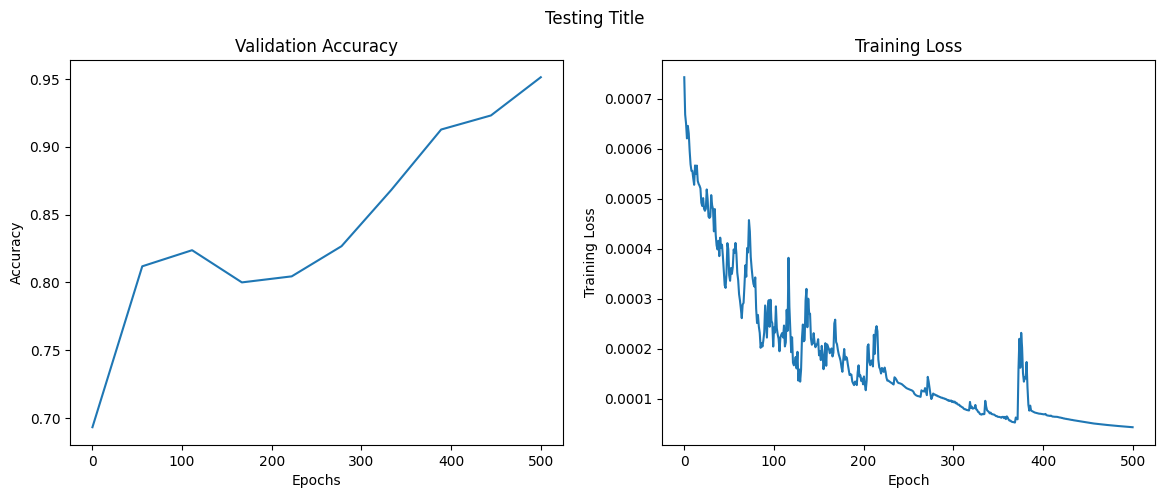

In [30]:
def displayResults(title = "Base Title", baseDirectory = "savedData/overTraining/", valName = "temp_val", lossName = "temp_loss", n_epochs = 50000):
    #Plot validation accuracies
    val = loadArray(baseDirectory + valName)
    fig, axs = plt.subplots(1,2,figsize=(14,5))
    fig.suptitle(title)
    axs[0].plot(np.linspace(0, n_epochs, len(val)), [m for m in val])
    axs[0].set(xlabel='Epochs', ylabel="Accuracy")
    axs[0].set_title('Validation Accuracy')

    # plot the loss values
    loss = loadArray(baseDirectory + lossName)
    axs[1].plot(np.linspace(0, n_epochs, len(loss)), [m for m in loss])
    axs[1].set(xlabel='Epoch', ylabel="Training Loss")
    axs[1].set_title('Training Loss')
    return

#Display dummy result
displayResults(title = "Testing Title", n_epochs=500)

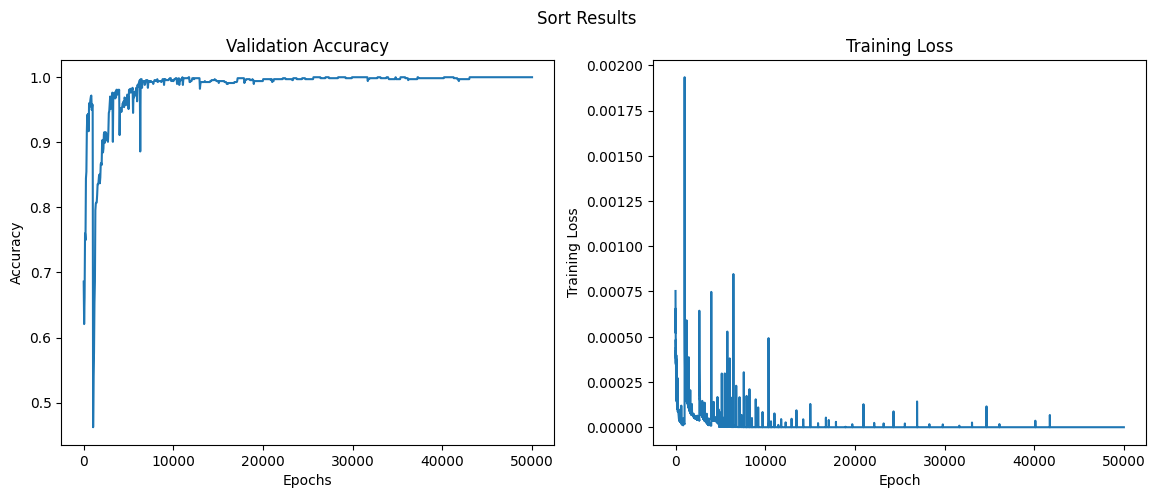

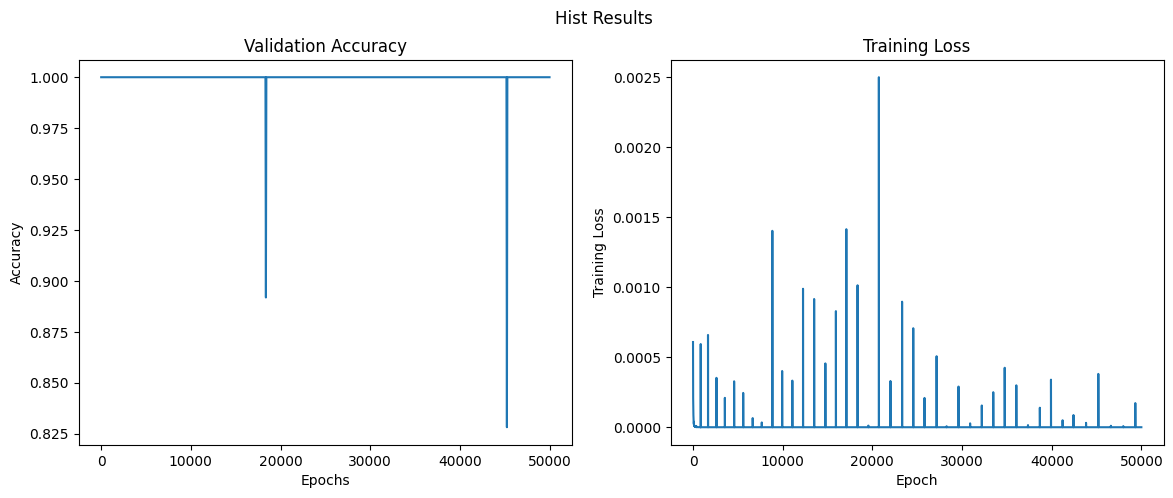

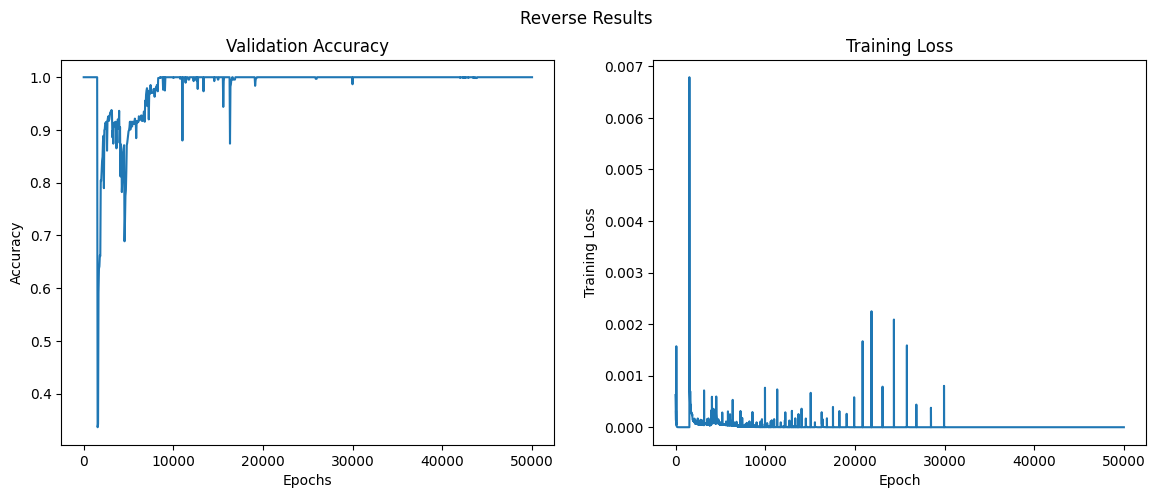

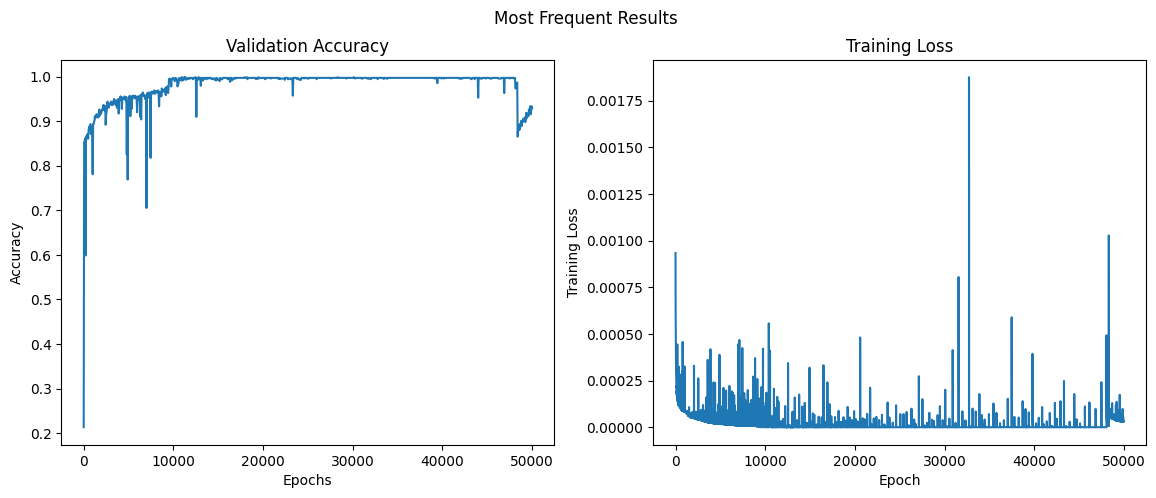

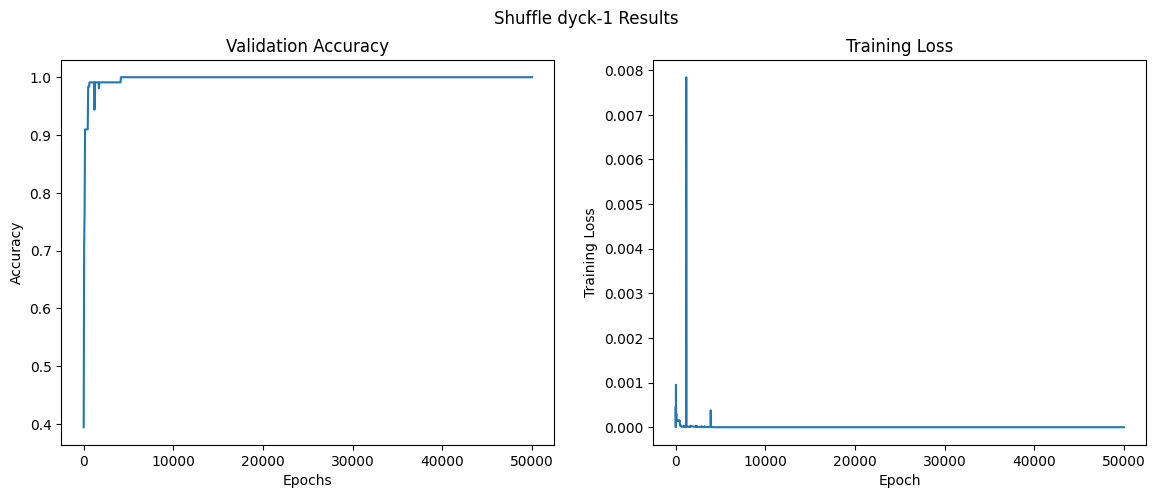

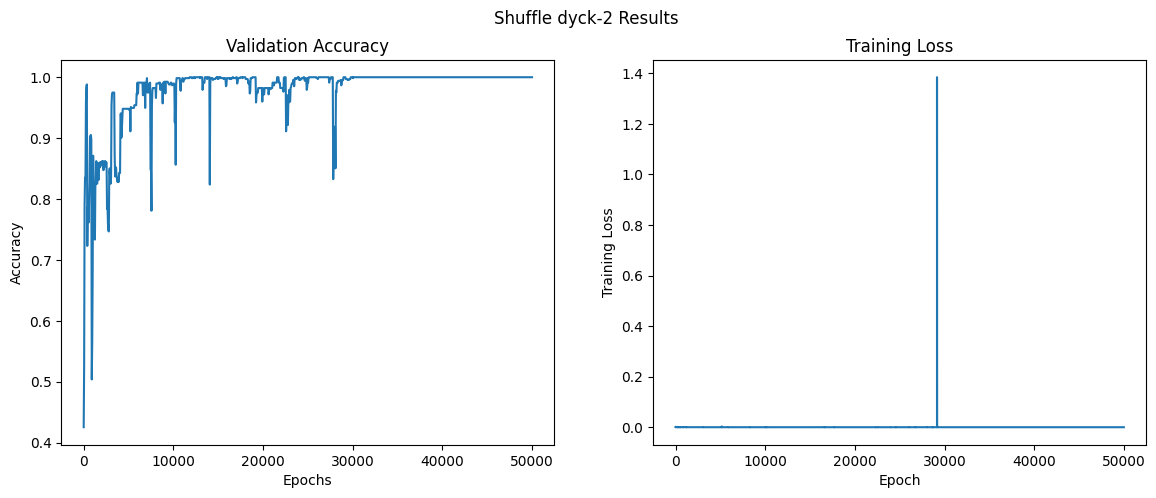

In [34]:
displayResults(title="Sort Results", valName="sort_val", lossName="sort_loss")
displayResults(title="Hist Results", valName="hist_val", lossName="hist_loss")
displayResults(title="Reverse Results", valName="reverse_val", lossName="reverse_loss")
displayResults(title="Most Frequent Results", valName="mostFreq_val", lossName="mostFreq_loss")
displayResults(title="Shuffle dyck-1 Results", valName="dyck1_val", lossName="dyck1_loss")
displayResults(title="Shuffle dyck-2 Results", valName="dyck2_val", lossName="dyck2_loss")